Enfoque del dataset de noticias falsas basado en CNN

In [1]:
### IMPORTS ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

import tensorflow as tf
tf.random.set_seed(55) # para asegurar experimentos son reproducibles
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Conv1D, MaxPooling1D

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

from sklearn.metrics import accuracy_score, classification_report 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import gensim.downloader as api

# Cargar Dataset

In [2]:
### ROOT DATA ###
import pathlib
PATH = str(pathlib.Path().resolve()).removesuffix('\FakeNews') + "\Datasets\Fakeddit"

In [3]:
### CONJUNTOS DE ENTRENAMIENTO, VALIDACIÓN Y TEST ###
df = pd.read_csv(PATH + "\\multimodal_train.tsv",  sep='\t', on_bad_lines='skip')
df = df[['clean_title', '6_way_label']]
df = df.rename(columns={"clean_title": "Text", "6_way_label": "Label"})
df.fillna(" ", inplace=True)

X_train = df['Text']
y_train = df['Label']

X_train, X_aux, y_train, y_aux = train_test_split(X_train, y_train, test_size=0.95, random_state=55, stratify=y_train)

df = pd.read_csv(PATH + "\\multimodal_validate.tsv",  sep='\t', on_bad_lines='skip')
df = df[['clean_title', '6_way_label']]
df = df.rename(columns={"clean_title": "Text", "6_way_label": "Label"})
df.fillna(" ", inplace=True)

X_val = df['Text']
y_val = df['Label']

X_val, X_aux, y_val, y_aux = train_test_split(X_val, y_val, test_size=0.95, random_state=55, stratify=y_val)

df = pd.read_csv(PATH + "\\multimodal_test_public.tsv",  sep='\t', on_bad_lines='skip')
df = df[['clean_title', '6_way_label']]
df = df.rename(columns={"clean_title": "Text", "6_way_label": "Label"})
df.fillna(" ", inplace=True)

X_test = df['Text']
y_test = df['Label']

X_test, X_aux, y_test, y_aux = train_test_split(X_test, y_test, test_size=0.95, random_state=55, stratify=y_test)

print('Tamaño conjunto de Entrenamiento:', len(X_train))
print('Tamaño conjunto de Validación:', len(X_val))
print('Tamaño conjunto de Evaluación:', len(X_test))

Tamaño conjunto de Entrenamiento: 28200
Tamaño conjunto de Validación: 2967
Tamaño conjunto de Evaluación: 2965


# Label Encoding

In [4]:
### LABEL ENCODING ###
y_train = y_train.tolist()
y_val = y_val.tolist()
y_test = y_test.tolist()

LABELS = sorted(set(y_train))
NUM_LABELS = len(LABELS)

idx2label={}
label2idx={}
for index, label in enumerate(LABELS):
    label2idx.update([(label, index)])
    idx2label.update([(index, label)])

print('Labels:', label2idx)
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_train_cat = to_categorical(y_train)
y_val = le.fit_transform(y_val)
y_val_cat = to_categorical(y_val)
y_test = le.fit_transform(y_test)
y_test_cat = to_categorical(y_test)

Labels: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}


# Tokenización

In [5]:
X_train = list(X_train)
X_val = list(X_val)
X_test = list(X_test)

tokenizer = Tokenizer(oov_token = True)
# entrenamos el tokenizador usando los textos del conjunto de entrenamiento
tokenizer.fit_on_texts(X_train)

# el índice 0, lo usamos para representar el token para padding
tokenizer.word_index['<PAD>'] = 0

NUM_WORDS=len(tokenizer.word_index)
print("Tamaño del vocabulario = {}".format(NUM_WORDS))

encoded_train = tokenizer.texts_to_sequences(X_train)
encoded_val = tokenizer.texts_to_sequences(X_val)
encoded_test = tokenizer.texts_to_sequences(X_test)

Tamaño del vocabulario = 25363


In [6]:
# Análisis de Longitud #
Length = pd.DataFrame({'Text': X_train})
Length['Length'] = Length['Text'].apply(lambda text: len(text.split()))
Length['Length'].describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

count    28200.000000
mean         7.482801
std          5.629102
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
90%         14.000000
95%         17.000000
99%         27.000000
max         96.000000
Name: Length, dtype: float64

In [7]:
MAX_LEN = 27

encoded_train = pad_sequences(encoded_train, maxlen = MAX_LEN, padding='post')
encoded_val = pad_sequences(encoded_val, maxlen = MAX_LEN, padding='post')
encoded_test = pad_sequences(encoded_test, maxlen = MAX_LEN, padding='post')

# Matriz de Embedding

In [8]:
#model_we = api.load("glove-wiki-gigaword-50")       #EMBED_SIZE = 50
model_we = api.load("word2vec-google-news-300")     #EMBED_SIZE = 300

EMBED_SIZE = 300

# creamos una matriz para los textos del conjunto de entrenamiento
embedding_matrix = np.zeros((NUM_WORDS, EMBED_SIZE))
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = model_we[word]
        # word embedding para la palabra con índice i
        embedding_matrix[i] = embedding_vector
    except:
        #if word does not exist, we do not udpate the matrix
        pass

# CNN

In [9]:
EMBEDDING_SIZE = EMBED_SIZE
model = Sequential()

model.add(Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=MAX_LEN, weights=[embedding_matrix]))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(NUM_LABELS, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

# Stop training when a monitored quantity has stopped improving.
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 27, 300)           7608900   
                                                                 
 conv1d (Conv1D)             (None, 27, 128)           153728    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 13, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 13, 64)            24640     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 6, 64)            0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 6, 32)             4

Training:

In [10]:
# Entrenamos el modelo
epochs = 20 # número de veces que pasamos sobre el conjunto de aprendizaje

#número de ejemplos que procesamos antes de acutalizar los pesos
batch_size = 16 

# training
history=model.fit(encoded_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_data=(encoded_val, y_val_cat), callbacks=[earlyStopping])


Epoch 1/20
1763/1763 [==============================] - 249s 139ms/step - loss: 0.9704 - accuracy: 0.6498 - val_loss: 0.8763 - val_accuracy: 0.6849
Epoch 2/20
1763/1763 [==============================] - 241s 137ms/step - loss: 0.6017 - accuracy: 0.7878 - val_loss: 0.9353 - val_accuracy: 0.6862
Epoch 3/20
1763/1763 [==============================] - 242s 137ms/step - loss: 0.2975 - accuracy: 0.8977 - val_loss: 1.1599 - val_accuracy: 0.6660
Epoch 4/20
1763/1763 [==============================] - 240s 136ms/step - loss: 0.1466 - accuracy: 0.9491 - val_loss: 1.4663 - val_accuracy: 0.6525


Curvas de Aprendizaje:

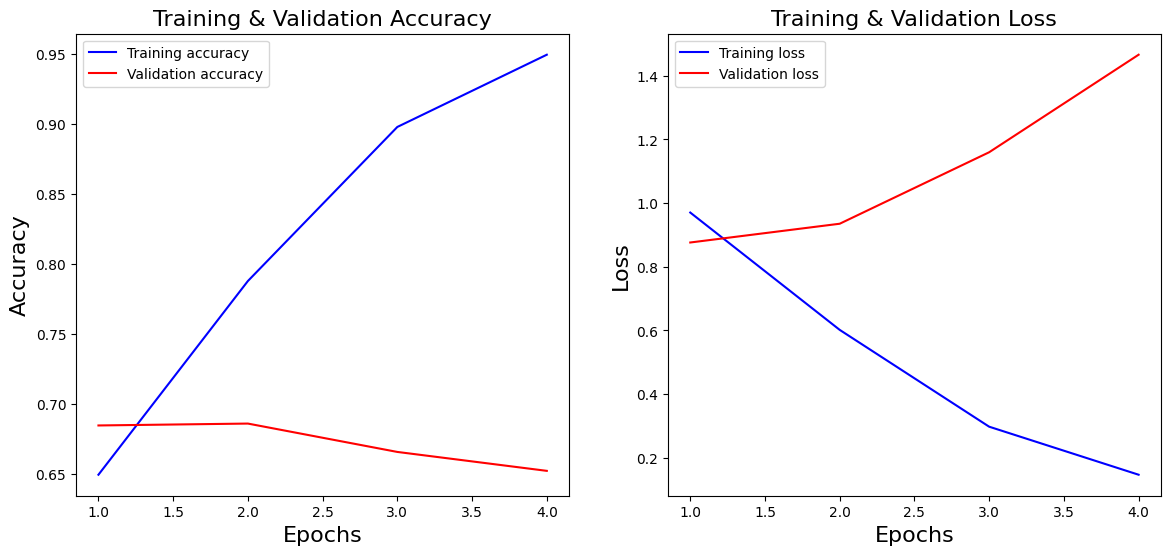

In [11]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the model accuracy vs Epochs
ax[0].plot(epochs, accuracy, 'b', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'red', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()

# Plot the loss vs Epochs
ax[1].plot(epochs, loss_values, 'b', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'red', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

Evaluación:

93/93 [==============================] - 1s 6ms/step
Accuracy: 0.6499156829679595
              precision    recall  f1-score   support

           0       0.77      0.72      0.74      1175
           1       0.39      0.20      0.26       176
           2       0.50      0.53      0.51       565
           3       0.17      0.26      0.21        61
           4       0.73      0.77      0.75       873
           5       0.36      0.51      0.42       115

    accuracy                           0.65      2965
   macro avg       0.49      0.50      0.48      2965
weighted avg       0.66      0.65      0.65      2965



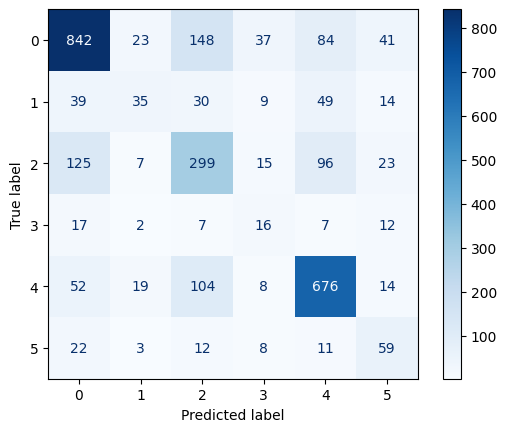

In [12]:
loss, accuracy = model.evaluate(encoded_test, y_test_cat, batch_size=batch_size)

y_pred = np.argmax(model.predict(encoded_test), axis=1)
print('Accuracy:', accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred, target_names=['0','1','2','3', '4', '5']))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0','1','2','3', '4', '5'])
disp.plot(cmap=plt.cm.Blues,values_format='g')